In [3]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [4]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0] ],
            ["H", [dist, 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [5]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04751 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50392 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72278 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82516 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86886 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88210 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87917 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86788 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85312 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83763 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82324 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81116 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80195 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79516 Exact Energy: -7.79545
Interatomic Distance

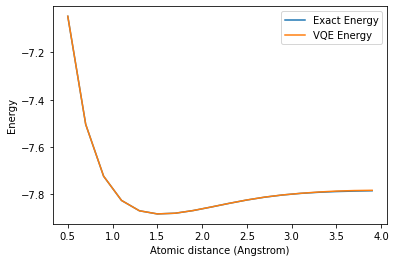

In [6]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [7]:
molecule = Molecule(
    geometry=[ ["H", [0.0, 0.0, -0.3625] ],
              ["H", [0.0, 0.0, 0.3625] ]],
    multiplicity=1,charge=0)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

mapper = ParityMapper()  # Set Mapper

hamiltonian = second_q_ops[0]  # Set Hamiltonian

# Do two qubit reduction
converter = QubitConverter(mapper,two_qubit_reduction=True)
reducer = TwoQubitReduction(num_particles)
qubit_op = converter.convert(hamiltonian)
qubit_op = reducer.convert(qubit_op)

In [9]:
from qiskit.providers.fake_provider import FakeManila
from qiskit.providers.aer import QasmSimulator

backend = Aer.get_backend('aer_simulator')
device_backend = FakeManila()
device = QasmSimulator.from_backend(device_backend)
NOISE_MODEL = None
coupling_map = device.configuration().coupling_map
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
qi= QuantumInstance(backend,
                    coupling_map=coupling_map,
                    noise_model=NOISE_MODEL,
                    measurement_error_mitigation_cls=CompleteMeasFitter)

In [10]:
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.11162983]


In [12]:
dist = 1.0
(qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
var_form = UCCSD(converter,
                    num_particles,
                    num_spin_orbitals,
                    initial_state=init_state)

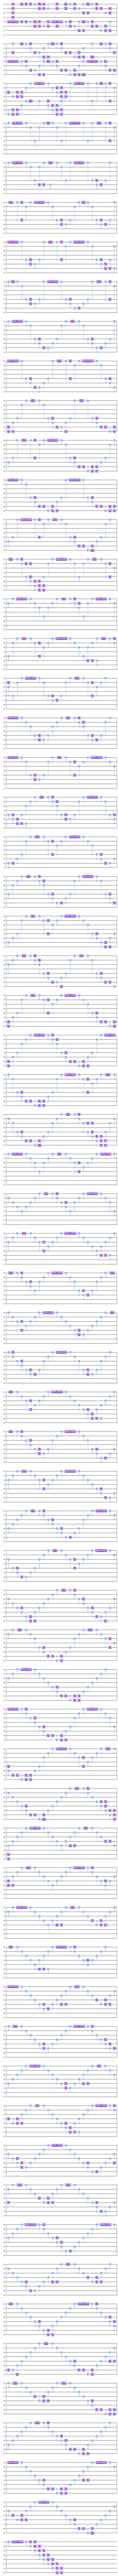

In [19]:
from qiskit.compiler import transpile
transpile(var_form, basis_gates=['ry', 'rx', 'rz', 'cx'], optimization_level=3).draw('mpl')